In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import IPython.display
import numpy.fft
from scipy import signal

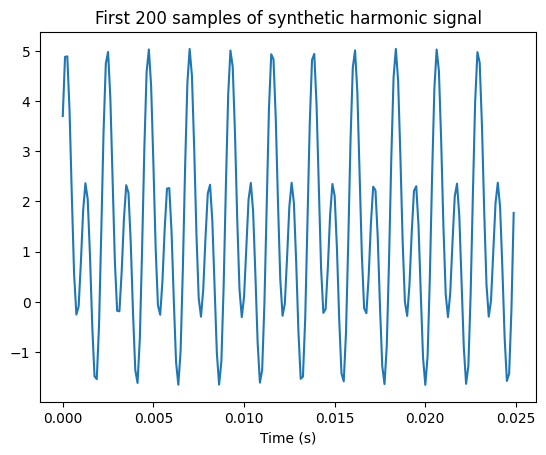

In [ ]:
# ============================================
# 1. サンプリングレートと時間軸の定義
# ============================================
sr = 8000
# 0秒から1秒未満までを 1/sr 秒刻みで生成
# → 長さ 1 秒の離散時間信号（8000 サンプル）に対応する時間軸
t = np.arange(0, 1, 1 / sr)

# ============================================
# 2. サイン波・コサイン波の振幅パラメータ
# ============================================
# a0: 直流成分（DC成分）＝時間によらず一定のオフセット
a0 = 1.4

# a, b はそれぞれコサイン成分・サイン成分の振幅を表す 2×1 ベクトル
# ここでは 1次の周波数成分と 2次の周波数成分（第1・第2高調波）に対して振幅を設定している。
#   a[0] → 1倍の周波数 f（基音）の cos 成分の振幅
#   a[1] → 2倍の周波数 2f（第2高調波）の cos 成分の振幅
#   b[0] → 1倍の周波数 f の sin 成分の振幅
#   b[1] → 2倍の周波数 2f の sin 成分の振幅
a = np.array([[0.9], [1.4]])
b = np.array([[1.2], [1.8]])

# ============================================
# 3. 基本周波数と高調波の設定
# ============================================
# f: 基本周波数 [Hz]。ここでは 440 Hz（A4 ラの音）を使用。
f = 440

# n: 高調波の番号（1倍, 2倍の周波数）
#   n = 1 → f = 440 Hz
#   n = 2 → 2f = 880 Hz
n = np.array([[1], [2]])

# ============================================
# 4. 波形の生成
# ============================================
# y = a0 +
#     Σ_n [ a_n cos(2π f n t) + b_n sin(2π f n t) ]
#
# という形の「有限個のサイン・コサインの線形結合」を作っている。
# これはフーリエ級数の基本形に相当し、
#   - a_n: cos 成分のフーリエ係数
#   - b_n: sin 成分のフーリエ係数
# とみなすことができる。
#
# ここでは n = 1,2 の 2つの周波数成分(440 Hz, 880 Hz)だけを足し合わせているため、
# 「2つの正弦波＋直流成分」で構成された周期信号になる。
y = a0 + np.sum(
    a * np.cos(2 * np.pi * f * n * t)  # cos 成分の和
    + b * np.sin(2 * np.pi * f * n * t),  # sin 成分の和
    axis=0,  # 高調波方向（n方向）に和を取る
)

# y の形状について：
#   - n: (2,1)
#   - t: (8000,) なので、n*t はブロードキャストにより (2,8000) の配列になる。
#   - a,b も (2,1) なので、各高調波ごとの振幅がそれぞれの行に対応。
#   - axis=0 で和を取ることで、2本の高調波を足し合わせた 1 次元信号 y (8000,) を得る。

# ============================================
# 5. 最初の 200 サンプルの時間波形を描画
# ============================================
# r: プロットしたいサンプルのインデックス（ここでは先頭 200 サンプル）
r = np.arange(0, 200)

# 先頭 200 サンプル分の時間と振幅をプロットすることで、
# 440 Hz と 880 Hz が重ね合わされた周期波形の形を可視化する。
plt.plot(t[r], y[r])
plt.xlabel("Time (s)")
plt.title("First 200 samples of synthetic harmonic signal")

# ============================================
# 6. 音として再生して確認
# ============================================
# IPython.display.Audio を使うことで、Jupyter Notebook 上で生成した波形を再生できる。
#   - data=y     : 再生する波形データ
#   - rate=sr    : サンプリングレート（ここでは 8000 Hz）
#
# 聴覚的には、「440 Hz の音」と「880 Hz の音」が混ざったトーンが聞こえるはずで、
# フーリエ級数による「複数周波数成分の重ね合わせ」が耳で確認できる。
IPython.display.Audio(y, rate=sr)

Text(0.5, 1.0, 'Magnitude spectrum of y (rFFT)')

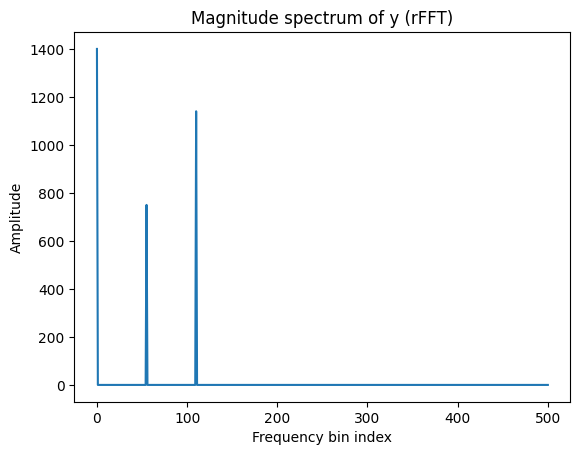

In [3]:
# ============================================
# 1. 直前までの図を閉じる
# ============================================
# すでに表示されているプロット（時間波形など）があれば閉じておく。
# Jupyter では必須ではないが、連続でプロットする際に図が重なって見づらくなるのを防ぐ目的。
plt.close()

# ============================================
# 2. FFT のサイズを指定
# ============================================
# nFFT: フーリエ変換で用いるサンプル数（FFT 長）。
#       ここでは 1000 点の FFT を使うことにする。
#       実際の信号 y の長さよりも小さくても大きくてもよく、
#       大きければゼロパディング／切り落としが行われる。
nFFT = 1000

# ============================================
# 3. 離散フーリエ変換（実数信号用 rFFT）
# ============================================
# np.fft.rfft:
#   実数値信号を対象とした 1 次元の高速フーリエ変換を行う関数。
#   実数信号の周波数スペクトルは共役対称になるため、
#   0〜ナイキスト周波数までの「正の周波数成分」だけを返す。
#
# S の中身は複素数であり、
#   |S[k]| が k 番目の周波数ビンの振幅（絶対値）、
#   arg(S[k]) が位相を表す。
#
# 第2引数 nFFT を与えることで、
#   - y が nFFT より短い場合：末尾に 0 をパディングして長さ nFFT にしてから FFT
#   - y が nFFT より長い場合：先頭 nFFT サンプルだけを使って FFT
# という形になる。
S = np.fft.rfft(y, nFFT)

# ============================================
# 4. 振幅スペクトルのプロット
# ============================================
# abs(S) で複素数スペクトルの絶対値（振幅）を取る。
# これは各周波数ビンごとの「エネルギーの強さ」の指標となる。
#
# x 軸は「周波数ビン番号」になっている。
# 実際の周波数 [Hz] に変換したい場合は、
#   freqs = np.fft.rfftfreq(nFFT, d=1/sr)
# などとして横軸を差し替えると良い。
plt.plot(abs(S))
plt.xlabel("Frequency bin index")
plt.ylabel("Amplitude")
plt.title("Magnitude spectrum of y (rFFT)")

In [4]:
import numpy as np

# ここでは、すでに以下が定義されている前提：
#   - y    : 440 Hz, 880 Hz 成分を含む信号
#   - sr   : サンプリングレート（ここでは 8000 Hz）
#   - nFFT : rFFT に使った FFT 長（ここでは 1000）
#   - S    : np.fft.rfft(y, nFFT) の結果（複素スペクトル）
#
# 上の前提で、S[55], S[110] の意味を確認しつつ値を表示する。

# 周波数ビンに対応する実周波数 [Hz] を計算
freqs = np.fft.rfftfreq(nFFT, d=1 / sr)

# 調べたいビン番号
k1 = 55  # 440 Hz 成分が乗ると期待されるビン
k2 = 110  # 880 Hz 成分が乗ると期待されるビン

# ==============================
# 1. S[55], S[110] の複素値
# ==============================
# S[k] は「k番目の周波数ビンの複素振幅（複素フーリエ係数）」を表す。
#   - 実部: cos 成分の寄与
#   - 虚部: sin 成分の寄与
# ここでは、
#   k=55  → f = k * sr / nFFT = 55 * 8000 / 1000 = 440 Hz
#   k=110 → f = 110 * 8000 / 1000 = 880 Hz
# なので、生成した信号の 440 Hz / 880 Hz 成分に対応するはずの点である。
print("S[55]  (bin 55, f = {:.1f} Hz):".format(freqs[k1]), S[k1])
print("S[110] (bin 110, f = {:.1f} Hz):".format(freqs[k2]), S[k2])

# ==============================
# 2. S[55] の振幅（絶対値）
# ==============================
# np.abs(S[55]) は、複素数 S[55] のノルム |S[55]| を返す。
# これは 440 Hz 成分の「振幅の大きさ」に対応しており、
# 元の信号の cos/sin の係数（a[0], b[0]）と、
# 取り出した区間の長さや窓の形（今回は NFFT=1000, 窓なし）で決まる。
amp_55 = np.abs(S[k1])
print("np.abs(S[55])  (440 Hz 成分の振幅):", amp_55)

# ==============================
# 3. S[55] の位相（角度）
# ==============================
# np.angle(S[55]) は、複素数 S[55] の偏角 arg(S[55]) をラジアンで返す。
#   - この値は「440 Hz 成分が時間 t=0 でどれだけ位相シフトしているか」を表す。
#   - 信号 y = A cos(2πft) + B sin(2πft) の形の場合、
#     A,B を極座標表現に変換することで振幅・位相表現に対応させられる。
phase_55_rad = np.angle(S[k1])  # [rad]
phase_55_deg = np.degrees(phase_55_rad)  # [deg] に変換しておくと直感的に理解しやすい

print("np.angle(S[55]) [rad]:", phase_55_rad)
print("np.angle(S[55]) [deg]:", phase_55_deg)

# 参考：
#   - 実際の FFT は有限長データに対する近似なので、
#     理論上の係数と完全に一致するとは限らない（区間の取り方・窓関数などによる）。
#   - 今回は NFFT=1000, sr=8000, f=440 なので、
#       1000 サンプル中の周期数 = f * NFFT / sr = 440 * 1000 / 8000 = 55
#     とちょうど整数周期分が含まれる。
#     そのため理論的には「周波数リークが少ない綺麗な 1 本の線スペクトル」となりやすい設定になっている。

S[55]  (bin 55, f = 440.0 Hz): (450.0000000000042-599.9999999999974j)
S[110] (bin 110, f = 880.0 Hz): (700.0000000000147-899.9999999999893j)
np.abs(S[55])  (440 Hz 成分の振幅): 750.0000000000005
np.angle(S[55]) [rad]: -0.9272952180016056
np.angle(S[55]) [deg]: -53.1301023541556


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

# ============================================
# 1. 直前までの図を閉じる
# ============================================
# すでに開いている Matplotlib の図をすべて閉じる。
# Notebook 上で連続してプロットする際、古い図が残って見づらくなるのを防ぐため。
plt.close()

# ============================================
# 2. 音声の読み込み（リサンプリングあり）
# ============================================
# 'a-falsetto.wav' という音声ファイルを読み込む。
# sr=8000 と明示することで、
#   - 元のファイルが何 Hz であっても
#   - 8000 Hz にリサンプリングして読み込む
# という動作になる。
#
# 理論的には、
#   ・サンプリングレート sr は「1秒あたりのサンプル数」であり、
#     離散時間信号 x[n] を連続時間に対応付けるときには t[n] = n / sr を用いる。
#   ・8000 Hz という値は、電話音声などでよく使われる帯域（ナローバンド音声）で、
#     0〜4000 Hz の周波数成分を表現できる（ナイキスト周波数 sr/2）。
y, sr = librosa.load("a-falsetto.wav", sr=8000)

# ============================================
# 3. 全体波形のプロット（時間方向のざっくり確認）
# ============================================
# まだ時間軸はサンプル番号（0,1,2,...）だが、
# 全体としてどのあたりに大きな音があるのかをざっくり見るのに使える。
plt.plot(y)
plt.title("Waveform (sample index vs amplitude)")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")

# ============================================
# 4. 局所区間（フレーム）の切り出し
# ============================================
# nFFT: これからフーリエ変換にかけるフレーム長（= FFT 長）を 1024 サンプルに設定。
#       sr = 8000 Hz なので、1024 サンプルは
#         1024 / 8000 ≒ 0.128 秒（約 128 ms）
#       の時間長の区間に相当する。
#
# 短時間フーリエ変換（STFT）の考え方では、
#   「信号は短い時間区間ではほぼ定常（周波数構造があまり変化しない）」
# と仮定し、その短い区間ごとに FFT をかけてスペクトルを解析する。
nFFT = 1024

# 2000 サンプル目（約 2000 / 8000 = 0.25 秒）あたりから、
# 長さ nFFT (=1024) サンプルの区間を取り出す。
# np.arange(nFFT) は 0 〜 1023 の整数配列。
# それに 2000 を足して 2000〜3023 のサンプルを指定している。
frame_indices = 2000 + np.arange(nFFT)

# 安全のため：もし音声が短すぎる場合はここでエラーになるので、
# 実際のコードでは len(y) をチェックするのが望ましい。
y_frame = y[frame_indices]

# 切り出した区間の波形をプロットしてみる。
# これにより、「この区間でどんな波形が入っているか」を時間領域で確認できる。
plt.figure()
plt.plot(y_frame)
plt.title("Raw frame (2000〜2000+1024 samples)")
plt.xlabel("Sample index within frame")
plt.ylabel("Amplitude")

# ============================================
# 5. ハニング窓（Hanning window）の適用
# ============================================
# STFT では、各フレームに窓関数（window function）を掛けてから FFT を行うのが一般的。
# ここでは np.hanning(nFFT) でハニング窓（ハン窓）を生成し、
# y_frame に対して要素ごとに掛けている。
#
# 理論的背景：
#   ・有限長フレームをそのまま切り出すと、「フレーム両端で信号がぶった切られる」ため、
#     周波数領域で強いスペクトルリーク（エネルギーのにじみ）が起こる。
#   ・ハニング窓は、フレームの端を 0 に近づける滑らかな形状を持ち、
#     端の不連続性を抑えることでスペクトルリークを軽減する。
#   ・その代わり、周波数分解能（メインローブの幅）とのトレードオフがある。
window = np.hanning(nFFT)
yWindow = y_frame * window

# 窓を掛けたあとの波形をプロット。
# 元のフレームと比べると、両端が滑らかに 0 に近づいている形になっているはず。
plt.figure()
plt.plot(yWindow)
plt.title("Windowed frame (Hanning window applied)")
plt.xlabel("Sample index within frame")
plt.ylabel("Amplitude")

# ============================================
# 6. フレームに FFT をかけてスペクトルを求める
# ============================================
# np.fft.rfft:
#   実数信号（ここでは窓付きフレーム yWindow）に対して、
#   0〜ナイキスト周波数までの「正の周波数成分」だけを返す高速フーリエ変換。
#
# 得られる S は複素数配列であり、
#   |S[k]| が振幅（スペクトルの大きさ）
#   arg(S[k]) が位相
# を表す。
S = np.fft.rfft(yWindow)

# ============================================
# 7. 周波数軸（何 Hz か）を計算
# ============================================
# np.fft.rfftfreq(nFFT, d) は、rFFT の各ビンに対応する周波数 [Hz] を計算する関数。
#   - 第1引数: FFT 長（ここでは nFFT）
#   - 第2引数: サンプリング周期 d = 1 / sr
#
# 結果として、
#   frequency[k] = k * sr / nFFT
# という配列が得られる。
frequency = np.fft.rfftfreq(nFFT, 1 / sr)

# ============================================
# 8. 振幅スペクトルのプロット
# ============================================
# np.abs(S) で複素スペクトル S の振幅（絶対値）を取り、
# 横軸を周波数 [Hz] としてプロットする。
#
# これにより、
#   ・この 128 ms 程度の短い時間区間で
#   ・どの周波数帯にエネルギーが集中しているか
# を視覚的に確認できる。
#
# falsetto（裏声）などの音声では、
#   - 基本周波数（ピッチ）付近に鋭いピーク
#   - その整数倍（高調波）に対応するピーク
# が見られることが多い。
plt.figure()
plt.plot(frequency, np.abs(S))
plt.title("Magnitude spectrum of windowed frame")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

# 必要に応じて、
# plt.xlim(0, 4000)  # などで帯域を絞ると見やすくなる（sr=8000 → ナイキスト 4000 Hz）
# plt.show()  # スクリプト実行時に明示的に図を表示したい場合

In [6]:
from scipy import signal
import numpy as np

# ここでは、すでに以下が定義されている前提：
#   - S         : np.fft.rfft(yWindow) で得た複素スペクトル（正の周波数側）
#   - frequency : np.fft.rfftfreq(nFFT, 1/sr) で得た各ビンに対応する周波数 [Hz]
#
# 今からやること：
#   周波数スペクトル |S| の中から「ピーク（山）」を検出し、
#   そのピークがどの周波数ビン（＝何 Hz）に位置しているかを求める。

# np.abs(S):
#   複素スペクトル S の絶対値を取ることで「振幅スペクトル（Magnitude Spectrum）」を得る。
#
# signal.find_peaks(y, distance, height) は 1次元信号 y の局所的な山（ピーク）を検出する関数。
#   - y        : ピークを探す対象（ここでは |S|：周波数ごとの振幅）
#   - distance : 隣接ピーク間の最小距離（サンプル数・ここではビン数）を指定。
#                → 40 ビン以上離れていないと別ピークとして認めない。
#                  高調波がある程度離れていることを前提に、
#                  細かいノイズ的な山をまとめて無視する役割を持つ。
#   - height   : ピークの高さの閾値。
#                → 1 未満の振幅のピークは無視する（小さなノイズを除外）。
#
# 戻り値はタプル (peaks, properties) で、
#   - peaks      : 検出されたピーク位置のインデックス配列（ここではビン番号）
#   - properties : 各ピークに関する追加情報（高さなど）を格納した辞書
#
# [0] を取ることで「ピーク位置のインデックス配列」だけを取り出している。
peaks = signal.find_peaks(np.abs(S), distance=40, height=1)[0]

# peaks は「スペクトル配列 |S| の中で、ピークと判定されたインデックス（k の値）」。
# 実際の周波数 [Hz] を知りたい場合は、frequency[peaks] を参照すればよい。
print("検出されたピークのビン番号:", peaks)
print("検出されたピークの周波数 [Hz]:", frequency[peaks])

# Jupyter Notebook などでは、セルの最後に変数名だけを書くと、その値が表示される。
# ここでは、配列 peaks の中身（ビン番号の一覧）が再度表示される。
peaks

検出されたピークのビン番号: [ 46  93 139 186]
検出されたピークの周波数 [Hz]: [ 359.375   726.5625 1085.9375 1453.125 ]


array([ 46,  93, 139, 186])

Text(0.5, 1.0, 'Magnitude spectrum with zero padding (N=8192)')

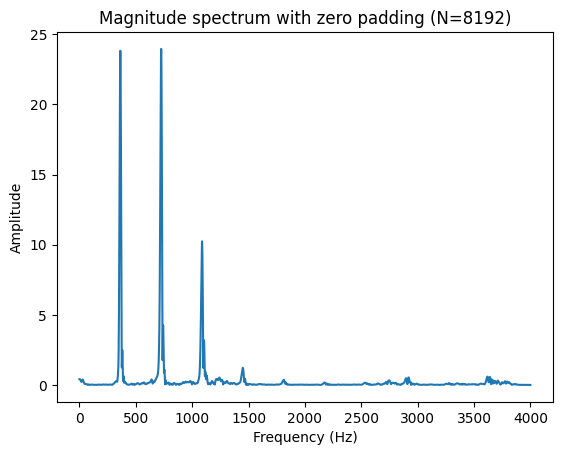

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ここでは、すでに以下が定義されている前提：
#   - yWindow : ハニング窓などを掛けた単一フレームの波形（1次元実数配列）
#   - sr      : サンプリングレート [Hz]
#
# yWindow に対して、より細かい周波数刻みでスペクトルを可視化するために
# 「ゼロパディング付き FFT（n=8192）」を行い、その結果をプロットする。

# ============================================
# 1. 既存の図をすべて閉じる
# ============================================
# plt.close() を複数回呼び出して、開いているウィンドウを片付ける。
# （plt.close('all') と書いてもよいが、ここでは連続で呼び出している。）
plt.close()
plt.close()
plt.close()
plt.close()

# ============================================
# 2. ゼロパディング付き rFFT の実行
# ============================================
# np.fft.rfft(yWindow, 8192) は、長さ len(yWindow) の信号 yWindow を
# 長さ 8192 の信号として扱って rFFT を計算する。
#
# ・もし len(yWindow) < 8192 の場合：
#     → 末尾に 0 を追加して長さ 8192 に拡張（ゼロパディング）
# ・もし len(yWindow) > 8192 の場合：
#     → 先頭 8192 サンプルのみを使う（ここでは通常前者を想定）
#
# 理論的なポイント：
#   - ゼロパディングは「周波数分解能（Δf = sr / N）」自体を改善するわけではない。
#   - しかし、スペクトルをより細かい周波数間隔でサンプリングしたものが得られるため、
#     「ピークの位置や形状を滑らかにプロットする」ことができる。
#   - ある意味、元のスペクトルを補間して滑らかに見せる操作と解釈できる。
SZeroPadding = np.fft.rfft(yWindow, 8192)

# ============================================
# 3. ゼロパディング後の周波数軸の計算
# ============================================
# np.fft.rfftfreq(8192, 1/sr) によって、
#   - N = 8192
#   - サンプリング周期 d = 1/sr
# の rFFT に対応する「正の周波数側の周波数配列（0〜sr/2）」が得られる。
#
# 各ビン k に対する実周波数は
#   f_k = k * sr / N
# で与えられ、N を大きくすると「周波数刻み sr/N」が細かくなる。
frequencyZeroPadding = np.fft.rfftfreq(8192, 1 / sr)

# ============================================
# 4. ゼロパディング後スペクトルのプロット
# ============================================
# np.abs(SZeroPadding) により、複素フーリエスペクトルの絶対値（振幅スペクトル）を計算し、
# 横軸を周波数 [Hz]、縦軸を振幅としてプロットする。
#
# 元の nFFT=1024 のスペクトルに比べて、
#   - ピークの形状がより滑らかに見える
#   - ピーク位置（周波数）をより細かく読み取れる
# という利点がある。
plt.plot(frequencyZeroPadding, np.abs(SZeroPadding))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Magnitude spectrum with zero padding (N=8192)")
# plt.xlim(0, sr/2)  # 必要に応じて帯域を制限すると見やすくなる
# plt.show()         # スクリプト実行の場合に明示的に表示したいとき